In [1]:
%gui tk
%matplotlib inline

import random
import numpy as np
import os
import tkinter as tk
from tkinter import filedialog
import pandas as pd
from glob import glob
from skimage import transform
import scipy.ndimage as ndi
import PIL.Image
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import h5py

c:\users\smirnovm\documents\python scripts\yad2k\venv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#to increase accuracy, all images should have the same initial pixel/µm resolution
SLIDING_WINDOW_SIDE = 256
SLIDING_WINDOW_STEP = 128
TARGET_SCALE = 10 #pix per um
# IMAGE_HEIGHT_FINAL = 416
# IMAGE_WIDTH_FINAL = 416
# IMAGE_CHANNELS = 3
# BOX_WIDTH = 15 #px
# BOX_HEIGHT = 15 #px

In [3]:
#initialize tkinter stuff
root = tk.Tk()
root.withdraw()

''

In [4]:
# Choose directory with image and coordinate folders
data_dir = os.path.normpath(filedialog.askdirectory())

In [14]:
# Create a dataframe for images and coordinates
all_images = glob(os.path.join(data_dir, '*.tif'))
img_df = pd.DataFrame({'img_path': all_images})
img_id = lambda in_path: in_path.split('\\')[-1]
img_df['ImageID'] = img_df['img_path'].map(img_id)

In [15]:
all_images
img_df['ImageID']

0    824-ab-63x-200.tif
1    824-ab-63x-201.tif
2    824-ab-63x-202.tif
3    824-ab-63x-203.tif
4    824-ab-63x-204.tif
5    824-ab-63x-205.tif
6    824-ab-63x-206.tif
Name: ImageID, dtype: object

In [18]:
# function to read images from files
def load_image(img_file):
    image = np.array(PIL.Image.open(img_file), dtype = np.uint8)
#     image = imread(img_file)
#     image = np.stack([image,image,image], 2)
    return image

In [19]:
# load images from files
img_df['images'] = img_df['img_path'].map(load_image)


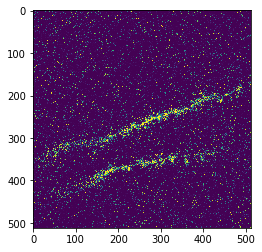

In [22]:
# show first image
plt.imshow(img_df['images'][0])

In [23]:
# function to convert all images to floats and make sure they are in a range of 0 and 1
def convert_images_to_float(image):
    image_float = image.astype(np.float16) / np.max(image)
    return image_float

In [24]:
img_df['images_float'] = img_df['images'].map(convert_images_to_float)

In [25]:
# create images of set size using sliding window
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            img_window = image[y:y + windowSize[1], x:x + windowSize[0]]
            yield (x, y, img_window)

In [26]:
#directory to save data
save_dir = os.path.normpath(filedialog.askdirectory())

In [28]:
# individually save all sliding window images to individual folders. 
# These will be loaded and preprocessed with the yolo program
file_list = []
for index, row in img_df.iterrows():
    if (index%500 == 0) & (index > 1):
        print('Splitting image #{}/{}'.format(index,len(img_df)))
    # make directory where all image windows will go
    image_dir = os.path.join(save_dir,'image{}'.format(index))
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
    for (x, y, window) in sliding_window(row['images_float'], stepSize=SLIDING_WINDOW_STEP, windowSize=(SLIDING_WINDOW_SIDE, SLIDING_WINDOW_SIDE)):
        window_file_path = os.path.join(image_dir,'window_x_{}_y_{}_data.npz'.format(x,y))
        file_list.append(window_file_path)
        np.savez(window_file_path,image = window)

np.savez(os.path.join(save_dir,'file_list.npz'),file_list = np.array(file_list))
print('Saving done yay')

Saving done yay
